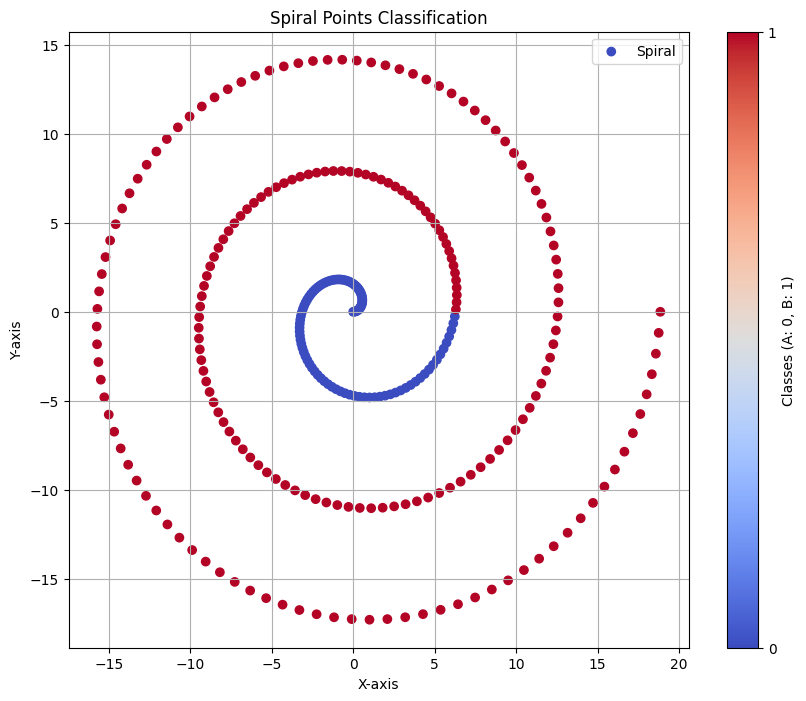

Accuracy of classification: 0.77


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate spiral points
def generate_spiral(t_max, revolutions, num_points_per_revolution):
    t = np.linspace(0, t_max, revolutions * num_points_per_revolution)
    x = t * np.cos(t)
    y = t * np.sin(t)
    return np.vstack((x, y)).T, t

# Classify points based on parameter t
def classify_points(t):
    return np.where(t <= 2 * np.pi, 'A', 'B')

# Create the spiral with 3 revolutions
t_max = 3 * 2 * np.pi
num_points_per_revolution = 100
points, t = generate_spiral(t_max, 3, num_points_per_revolution)

# Create labels
labels = classify_points(t)

# Convert labels to numerical values for classification
label_numerical = np.where(labels == 'A', 0, 1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(points, label_numerical, test_size=0.2, random_state=42)

# Perform Kernel Ridge Regression for classification
model = KernelRidge(kernel='rbf')
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_class = np.round(y_pred).astype(int)  # round to get class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(points[:, 0], points[:, 1], c=label_numerical, cmap='coolwarm', label='Spiral')
plt.title('Spiral Points Classification')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(ticks=[0, 1], label='Classes (A: 0, B: 1)')
plt.legend()
plt.grid()
plt.show()

print(f'Accuracy of classification: {accuracy:.2f}')
